In [1]:
import os
import torch
import numpy as np
import pandas as pd

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

/home/czhao/multimodal/Diffusion-TS/.venv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/unemploy.yaml'
        self.save_dir = './OUTPUT/unemploy'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')
print(device)
dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

cuda:0


sampling loop time step: 100%|██████████| 500/500 [00:18<00:00, 27.23it/s]


PCA Analysis


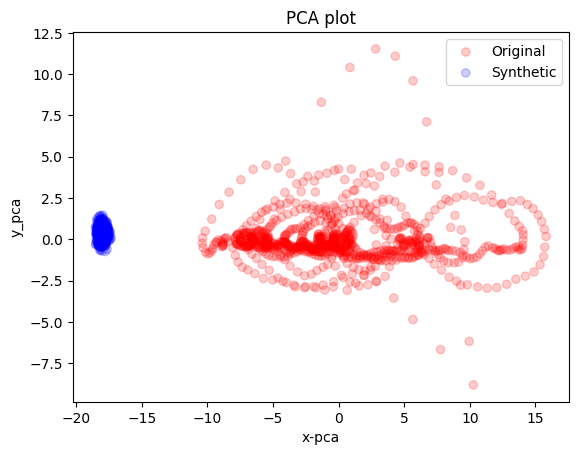

t-SNE Plot
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1826 samples in 0.003s...
[t-SNE] Computed neighbors for 1826 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1826
[t-SNE] Computed conditional probabilities for sample 1826 / 1826
[t-SNE] Mean sigma: 0.542713


/home/czhao/multimodal/Diffusion-TS/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.660728
[t-SNE] KL divergence after 300 iterations: 1.465714


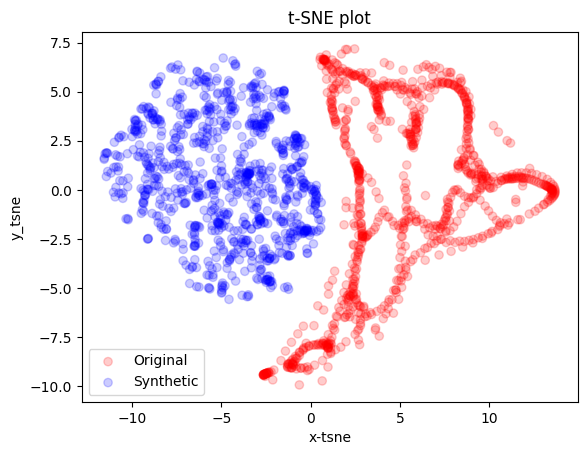

Data Density


/home/czhao/multimodal/Diffusion-TS/Utils/metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/czhao/multimodal/Diffusion-TS/Utils/metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

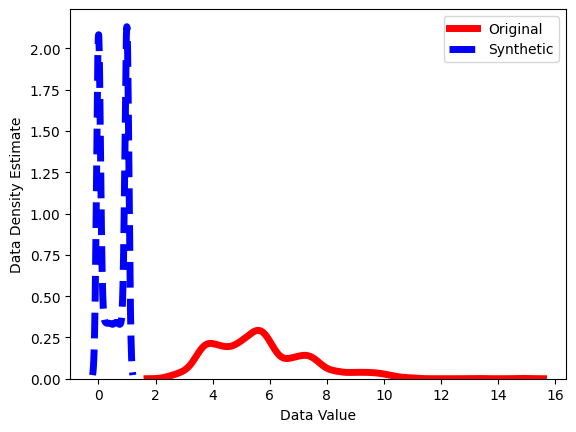

In [4]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"unemployment_missing_ground_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_unemploy.npy'), fake_data)

In [ ]:
# visualization
print("PCA Analysis")
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

print("t-SNE Plot")
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

print("Data Density")
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])

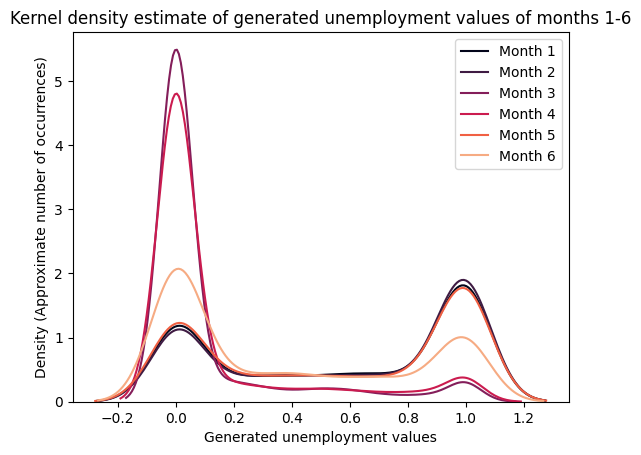

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# reshape and convert numpy array to dataframe
fake_data_reshaped = fake_data.reshape(fake_data.shape[0], fake_data.shape[1])
df_generated = pd.DataFrame(fake_data_reshaped)

months = ['Month ' + str(i+1) for i in range(12)]
df_generated.columns = months # add descriptive feature names

# plotting density of values
# kde is like a histogram
n = 6
fig, ax = plt.subplots()
norm = mcolors.Normalize(vmin=0, vmax=n)
cmap = cm.get_cmap("rocket")

for i in range(n):
    color = cmap(norm(i))
    sns.kdeplot(df_generated[months[i]], ax=ax, label=months[i], color=color)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.legend()
plt.xlabel('Generated unemployment values')
plt.ylabel('Density (Approximate number of occurrences)') 
plt.title('Kernel density estimate of generated unemployment values of months 1-6')
plt.show()

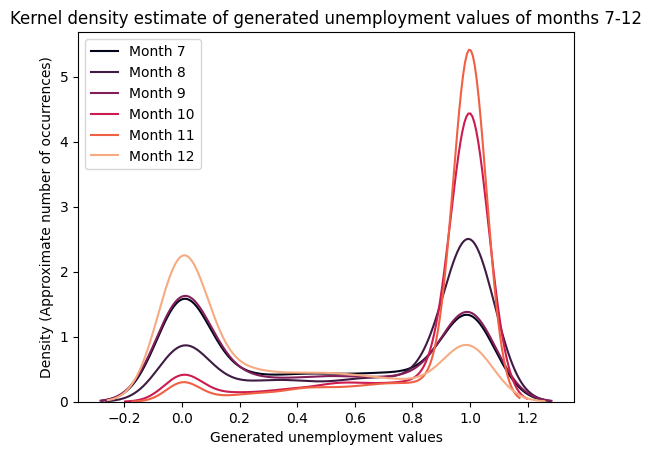

In [113]:
# plotting density of values
fig, ax = plt.subplots()
# n = len(df_generated.columns)
n = 6
norm = mcolors.Normalize(vmin=0, vmax=n)
cmap = cm.get_cmap("rocket")

for i in range(n):
    color = cmap(norm(i))
    sns.kdeplot(df_generated[months[i+6]], ax=ax, label=months[i+6], color=color)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.legend()
plt.xlabel('Generated unemployment values')
plt.ylabel('Density (Approximate number of occurrences)') 
plt.title('Kernel density estimate of generated unemployment values of months 7-12')
plt.show()

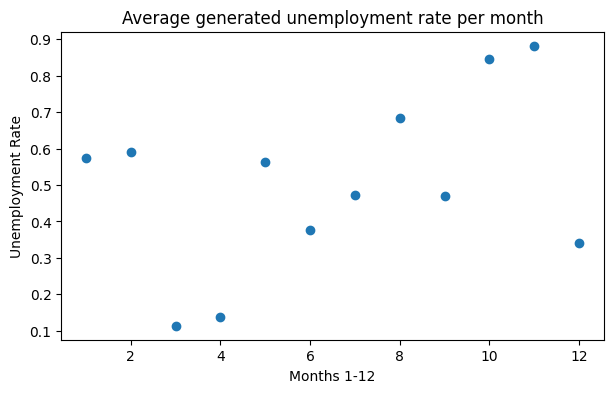

In [148]:
# checking the means
means = []
month_idx = [i+1 for i in range(12)]
for i in range(len(df_generated.columns)):
    col_mean = df_generated[months[i]].mean()
    means.append(col_mean)

plt.figure(figsize=(7, 4))
plt.scatter(month_idx, means)
plt.title('Average generated unemployment rate per month')
plt.xlabel('Months 1-12')
plt.ylabel('Unemployment Rate')
plt.show()

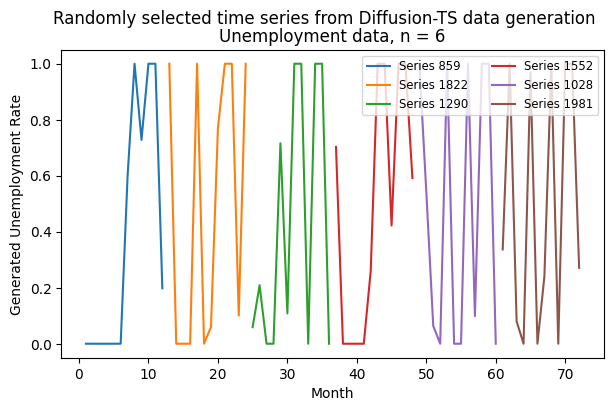

In [161]:
# graphing random sample of generated time series
num_samples = 6
month_idx = [i+1 for i in range(12)]
plt.figure(figsize=(7, 4))
random_rows = df_generated.sample(n=num_samples, random_state=25)
for i, row in random_rows.iterrows():
    plt.plot(month_idx, row.values, label=f"Series {i}")
    month_idx = [month_idx[j]+12 for j in range(len(month_idx))] # update month indices

plt.xlabel("Month")
plt.ylabel("Generated Unemployment Rate")
plt.title(f"Unemployment data, n = {num_samples}")
plt.suptitle("Randomly selected time series from Diffusion-TS data generation")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.show()

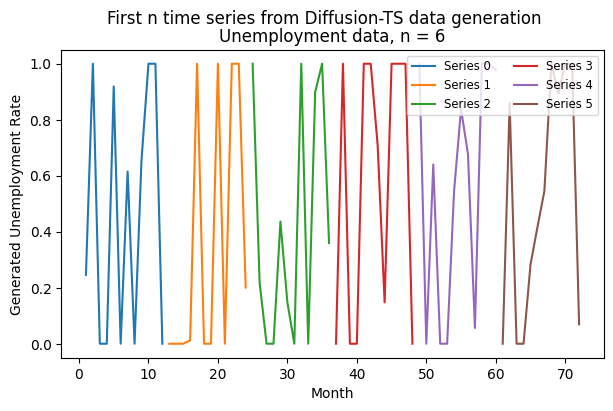

In [ ]:
# graphing first n samples of generated time series
num_samples = 6
month_idx = [i+1 for i in range(12)]
plt.figure(figsize=(7, 4))
for i in range(num_samples):
    plt.plot(month_idx, df_generated.iloc[i].values, label=f"Series {i}") 
    month_idx = [month_idx[j]+12 for j in range(len(month_idx))] # update month indices

plt.xlabel("Month")
plt.ylabel("Generated Unemployment Rate")
plt.title(f"Unemployment data, n = {num_samples}")
plt.suptitle("First n time series from Diffusion-TS data generation")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.show()

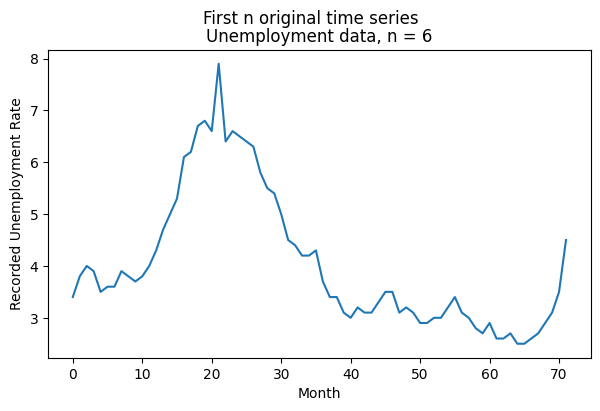

In [179]:
# plotting original data
og_fp = 'Data/datasets/unemployment.csv'
df_og = pd.read_csv(og_fp)
num_samples = 6

plt.figure(figsize=(7, 4))
plt.plot(df_og.iloc[:(num_samples*12)])

plt.xlabel("Month")
plt.ylabel("Recorded Unemployment Rate")
plt.title(f"Unemployment data, n = {num_samples}")
plt.suptitle("First n original time series")
plt.show()

# plt.plot(df_og)